## Observational overdensities

Comparison to observed overdensities.

In [1]:
import pandas as pd
import numpy as np

import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from scipy.optimize import curve_fit

from astropy.cosmology import Planck13

from methods import z_distort, factor_h, get_protoclusters, label, binit, \
    fit_func, r2, overdensity_cylinder, bhattacharyya, plotit

h = 0.673
L = 480.279 / h # box side length

N = 100000    # number of random regions

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory = 'output/'

redshifts = ['2p07','3p10','3p95','5p03','5p92']  #,'8p22','8p93','9p72'] , ,,,'6p97'
zees = [float(z.replace('p','.')) for z in redshifts]

### Load data

In [3]:
gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)
gals_sfr5 = [None] * len(redshifts)

for i, (z, zed) in enumerate(zip(redshifts, zees)):
    print i, z
    
#     gals_sfr[i] = z_distort(factor_h(pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), 
#                               skiprows=122, skipfooter=1, engine='python'), h), zed, L)
    
#     gals_sfr5[i] = gals_sfr[i][gals_sfr[i]['zn_sfr'] > 5]
    
    gals_mstar[i] = z_distort(factor_h(pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), 
                                skiprows=122, skipfooter=1, engine='python'), h), zed, L)
    

0 2p07
1 3p10
2 3p95
3 5p03
4 5p92


In [6]:
gals_mstar10 = [None] * len(redshifts)

for i, z in enumerate(zees):
        
#     gals_mstar[i] = z_distort(factor_h(gals_mstar[i], h), z, L)

    gals_mstar10[i] = gals_mstar[i][gals_mstar[i]['zn_stellarMass'] >= 1]

#         print "Filling in NaN values..."
    gals_mstar10[i].loc[np.isnan(gals_mstar10[i]['z0_haloId']), 'z0_haloId'] = -1
    gals_mstar10[i].loc[np.isnan(gals_mstar10[i]['z0_centralId']), 'z0_centralId'] = -1
    gals_mstar10[i].loc[np.isnan(gals_mstar10[i]['z0_central_mcrit200']), 'z0_central_mcrit200'] = 0
    

### Franck & McGaugh +16

Write protocluster candidate data in to a dataframe for ease of use. Redshift depth given by $z \pm \sigma_{z}$.

In [7]:
name = ['CCPC-z27-002','CCPC-z29-001','CCPC-z29-002','CCPC-z30-001','CCPC-z30-003','CCPC-z31-003',
        'CCPC-z31-004','CCPC-z31-005','CCPC-z32-002','CCPC-z33-002','CCPC-z35-001','CCPC-z36-001']

redshift = [2.772,2.918,2.919,3.035,3.096,3.133,3.146,3.152,3.234,3.372,3.597,3.644]
deltaz = [0.007,0.005,0.009,0.005,0.008,0.008,0.006,0.007,0.003,0.008,0.003,0.003]

In [8]:
dat = pd.DataFrame(data=[redshift, deltaz]).T
dat.index = name
dat.columns = ['redshift','deltaz']

Calculate $\Delta z$ in $\mathrm{cMpc}$

In [9]:
dat['deltac'] = (Planck13.comoving_distance(dat.redshift+dat.deltaz) - \
                 Planck13.comoving_distance(dat.redshift-dat.deltaz))

Add empty columns for calculated protocluster probabilities, and nearest redshift snapshot in Millennium.

In [10]:
# dat['protocluster probability'] = pd.Series()
# dat['high mass probability'] = pd.Series()
# dat['part probability'] = pd.Series()
dat['dgal'] = [11.02,11.21,12.91,18.78,12.28,9.80,7.59,17.77,13.11,7.44,10.18,23.50]
dat['nearest snap'] = [3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.95,3.95]

dat

,redshift,deltaz,deltac,dgal,nearest snap
CCPC-z27-002,2.772,0.007,14.904643,11.02,3.10
CCPC-z29-001,2.918,0.005,10.078235,11.21,3.10
CCPC-z29-002,2.919,0.009,18.134164,12.91,3.10
CCPC-z30-001,3.035,0.005,9.657593,18.78,3.10
CCPC-z30-003,3.096,0.008,15.119127,12.28,3.10
CCPC-z31-003,3.133,0.008,14.922752,9.80,3.10
CCPC-z31-004,3.146,0.006,11.141042,7.59,3.10
CCPC-z31-005,3.152,0.007,12.970569,17.77,3.10
CCPC-z32-002,3.234,0.003,5.402721,13.11,3.10
CCPC-z33-002,3.372,0.008,13.748392,7.44,3.10


#### Calculate overdensity data

Need to calculate overdensity statistics for random regions over the whole box in order to get probabilities. 

First, find the coordinates of all protoclusters

In [11]:
group_coods = [None] * len(gals_mstar10)
group_coods[0] = get_protoclusters(gals_mstar10[0], L, cluster_lim=1e3)
group_coods[1] = get_protoclusters(gals_mstar10[1], L, cluster_lim=1e3)

Use to find limiting completeness and purity, and calculate overdensity stats.

In [13]:
# coods = pd.DataFrame(np.random.rand(N,3) * L, columns=['zn_x','zn_y','zn_z']) # generate random regions

# out_stats = {str(idx): {'stats': None, 'dgal': None, 'cmass': None, 'clim': None, 'plim': None} \
#                            for idx in dat.index}

gal_idx = [0,0,0,0,0,0,0,0,0,0,1,1]

# for didx, gidx in zip(dat.index, gal_idx):
#     print didx, gidx

#     pc_mask = group_coods[gidx]['clusters']['z0_central_mcrit200'].values > 1e4
    
# #     print 'finding clim and plim' for protoclusters
#     c_p = overdensity_cylinder(gals_mstar10[gidx], group_coods[gidx]['coods'], 
#                         R=10, dc=dat.ix[didx]['deltac'] / 2, L=L, pc_stats=True)
    
#     out_stats[didx]['clim'] = (round(np.percentile(c_p[pc_mask,1], 95),3), 
#                                round(np.median(c_p[pc_mask,1])),
#                                round(np.percentile(c_p[pc_mask,1], 5),3))
    
#     out_stats[didx]['plim'] = (round(np.percentile(c_p[pc_mask,2], 95),3), 
#                                round(np.median(c_p[pc_mask,2])), 
#                                round(np.percentile(c_p[pc_mask,2], 5),3))
    
#     out_stats[didx]['dgal'] = c_p[:,0]
#     out_stats[didx]['cmass'] = group_coods[gidx]['clusters']['z0_central_mcrit200'].values
    
# # #     print 'calculating stats'
# #     out_stats[didx]['stats'] = overdensity_cylinder(gals_mstar10[gidx], coods, R=10, 
# #                             dc=dat.ix[didx]['deltac'], L=L, pc_stats=True, verbose=False)
    

# pcl.dump(out_stats, open('out_stats_obs.p','w'))
out_stats = pcl.load(open(directory+'out_stats_obs.p','r'))

In [14]:
# pcl.dump(out_stats, open('out_stats_obs.p','w'))

Add overdensity uncertainty

In [15]:
dat['dgal_sig'] = [6.90, 4.76, 4.55, 10.14, 2.42, 2.77, 4.65, 9.19, 8.63, 4.47, 8.05, 14.39]

Calculate protocluster probabilities and estimate descendant masses:

In [16]:
minimum = 5
N = 18

In [19]:
dat['clim'] = np.nan
dat['plim'] = np.nan
dat['dgal_threshold'] = np.nan

for idx in dat.index:  # loop through observational candidates
    
    ### Protocluster Probability 
    if out_stats[idx]['clim'][2] < 0.1: dat.loc[idx]['clim'] = 0.01
    else: dat.loc[idx]['clim'] = out_stats[idx]['clim'][2] - 0.1
        
    if out_stats[idx]['plim'][2] < 0.1: dat.loc[idx]['plim'] = 0.01
    else: dat.loc[idx]['plim'] = out_stats[idx]['plim'][2] - 0.1
    
    labs, labels = label(out_stats[idx]['stats'], clim=dat.loc[idx]['clim'], plim=dat.loc[idx]['plim'])

    bins, binLimits, agg, agg_total, fracs = binit(out_stats[idx]['stats'], labs, labels, N=N, minimum=minimum)
    
    dgal = dat.loc[idx]['dgal']
    keys = labels[:4]
    
    print idx, "\nClim:", out_stats[idx]['clim'], "\nPlim:", out_stats[idx]['plim'], "\nP(dgal): %.3f"%\
    np.sum([fracs[key] for key in keys], axis=0)[np.where(binLimits < dgal)[0].max()], "\n"
    
    ### Descendant Mass Estimate 
    dat.loc[idx]['dgal_threshold'] = np.mean(out_stats[idx]['dgal'][out_stats[idx]['cmass'] > 1e4]) + 1.5
    
    fit_mask = out_stats[idx]['dgal'] > dat.loc[idx]['dgal_threshold']

    x = np.zeros((out_stats[idx]['dgal'].shape[0], 2))  # create feature array

    x[:,0] = out_stats[idx]['dgal']
    x[:,1] = dat.loc[idx]['redshift']

    popt, pcov = curve_fit(fit_func, x[fit_mask,:].T, out_stats[idx]['cmass'][fit_mask], maxfev=20000)
    
    print "R^2: %.2f \nM_z=0: %.2f\n"%(r2(out_stats[idx]['cmass'][fit_mask], fit_func(x[fit_mask,:].T, popt[0], popt[1], popt[2], popt[3])),\
    np.log10(fit_func(dat.loc[idx][['dgal','redshift']], popt[0], popt[1], popt[2], popt[3]) * 1e10))
    

CCPC-z27-002 
Clim: (1.0, 1.0, 0.821) 
Plim: (0.889, 1.0, 0.375) 
P(dgal): 0.799 

R^2: 0.65 
M_z=0: 14.78

CCPC-z29-001 
Clim: (1.0, 1.0, 0.692) 
Plim: (0.935, 1.0, 0.444) 
P(dgal): 0.567 

R^2: 0.64 
M_z=0: 14.62

CCPC-z29-002 
Clim: (1.0, 1.0, 0.863) 
Plim: (0.864, 1.0, 0.347) 
P(dgal): 0.957 

R^2: 0.63 
M_z=0: 15.01

CCPC-z30-001 
Clim: (1.0, 1.0, 0.668) 
Plim: (0.94, 1.0, 0.45) 
P(dgal): 0.913 

R^2: 0.64 
M_z=0: 15.02

CCPC-z30-003 
Clim: (1.0, 1.0, 0.825) 
Plim: (0.889, 1.0, 0.375) 
P(dgal): 0.929 

R^2: 0.65 
M_z=0: 14.88

CCPC-z31-003 
Clim: (1.0, 1.0, 0.821) 
Plim: (0.889, 1.0, 0.375) 
P(dgal): 0.799 

R^2: 0.65 
M_z=0: 14.69

CCPC-z31-004 
Clim: (1.0, 1.0, 0.727) 
Plim: (0.926, 1.0, 0.429) 
P(dgal): 0.299 

R^2: 0.65 
M_z=0: 14.30

CCPC-z31-005 
Clim: (1.0, 1.0, 0.786) 
Plim: (0.906, 1.0, 0.4) 
P(dgal): 0.912 

R^2: 0.65 
M_z=0: 15.09

CCPC-z32-002 
Clim: (1.0, 1.0, 0.419) 
Plim: (1.0, 1.0, 0.5) 
P(dgal): 0.418 

R^2: 0.51 
M_z=0: 14.49

CCPC-z33-002 
Clim: (1.0, 1.0, 0.8) 

0 CCPC-z27-002
0
1 CCPC-z29-001
2 CCPC-z29-002
3 CCPC-z30-001
4 CCPC-z30-003
5 CCPC-z31-003
6 CCPC-z31-004
6
7 CCPC-z31-005
8 CCPC-z32-002
9 CCPC-z33-002
10 CCPC-z35-001
11 CCPC-z36-001


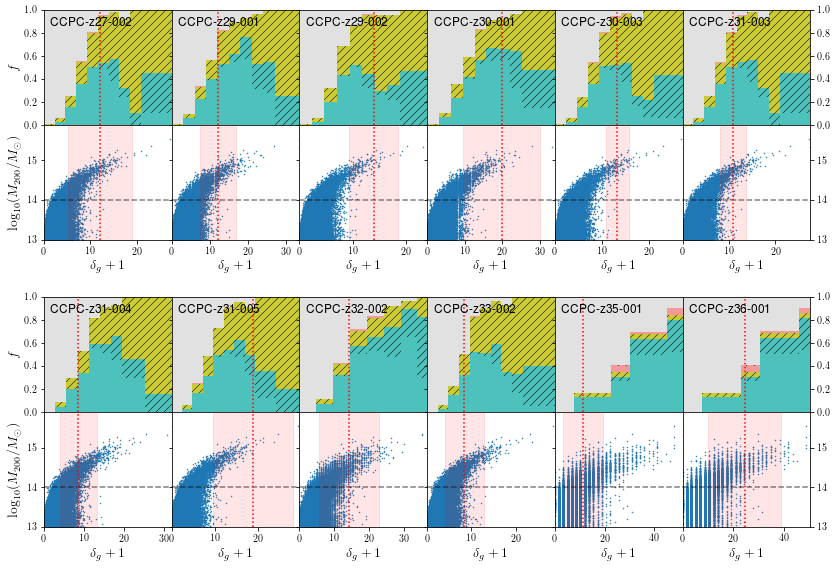

In [37]:
fig = plt.figure(figsize=(14, 8))

gs = gridspec.GridSpec(9, 7)
gs.update(hspace=0, wspace=0)



axt = {'top': [None] * 6, 'bottom': [None] * 6}
axb = {'top': [None] * 6, 'bottom': [None] * 6}

for i in range(6):
    
    axt['top'][i] = fig.add_subplot(gs[0:2,i])
    axt['bottom'][i] = fig.add_subplot(gs[2:4,i])
    
    axb['top'][i] = fig.add_subplot(gs[5:7,i])
    axb['bottom'][i] = fig.add_subplot(gs[7:9,i])


for i, idx in enumerate(dat.index):
    
    print i, idx
    
    if i < 6:
        ax = {'top': axt['top'][i], 'bottom': axt['bottom'][i]}
    else:
        ax = {'top': axb['top'][i-6], 'bottom': axb['bottom'][i-6]}
    
#     fig, ax = plt.subplots(1, 2, figsize=(6,2.5))
    
    ax['top'].text(0.05, 0.87, u'%s'%idx, size=12, transform=ax['top'].transAxes)
#     ax[1].text(1.2, 0.6, u'$C_{lim}$: %.3f'%dat.ix[idx]['clim'], size=15, transform=ax[1].transAxes)
#     ax[1].text(1.2, 0.4, u'$P_{lim}$: %.3f'%dat.ix[idx]['plim'], size=15, transform=ax[1].transAxes)
#     ax[1].text(1.2, 0.2, u'$R$: %.2f Dc: %.2f'%(20, dat.ix[idx]['deltac']), size=15, transform=ax[1].transAxes)

    plotit(ax['top'], out_stats[idx]['stats'], axb=None, N=N, clim=dat.ix[idx]['clim'], 
           plim=dat.ix[idx]['plim'], minimum=minimum);
    
    fit_mask = out_stats[idx]['dgal'] > dat.ix[idx]['dgal_threshold'];
    
    if (i == 0) | (i == 6):
        print i
        ax['top'].set_ylabel('$f$', size=14)
        ax['bottom'].set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$', size=14)
    elif (i==5) | (i==11):
        ax['top'].yaxis.set_ticks_position('right')
        ax['bottom'].yaxis.set_ticks_position('right')
    else:
        ax['top'].set_yticklabels([])
        ax['bottom'].set_yticklabels([])
        
    
        
        
    ax['top'].set_xticklabels([])
    ax['bottom'].set_xlabel('$\delta_{g} + 1$', size=14)

#     x = np.zeros((out_stats[idx]['dgal'].shape[0], 2));  # create feature array

#     x[:,0] = out_stats[idx]['dgal'];
#     x[:,1] = dat.ix[idx]['redshift'];

#     popt, pcov = curve_fit(fit_func, x[fit_mask,:].T, out_stats[idx]['cmass'][fit_mask], maxfev=20000);

    ax['bottom'].plot(out_stats[idx]['dgal'] + 1, np.log10(out_stats[idx]['cmass'] * 1e10), '.', markersize=1);

#     dgal_range = np.linspace(dat.ix[idx]['dgal_threshold'], out_stats[idx]['dgal'].max() + 1, len(x[:,1]));

#     ax[1].plot(dgal_range, scale(fit_func(np.vstack([dgal_range, x[:,1]]), popt[0], popt[1], popt[2], popt[3])));

#     ax[1].vlines(dat.ix[idx]['dgal_threshold'], 13,16,linestyle='dashed', alpha=0.5, zorder=10);
    
    ax['bottom'].set_ylim(13,15.9);
    
    # add observational values
    
#     dgal =  [None,None,None]
#     dgal[0] = chiang13[key]['dgal_chiang'][0] + 1
#     dgal[1] = dgal[0] + chiang13[key]['dgal_chiang'][1]
#     dgal[2] = dgal[0] - chiang13[key]['dgal_chiang'][2]
    
#     print key, dgal, chiang13[key]['dgal_chiang']

#     ax['bottom'].axvspan(dgal[1], dgal[2], color='red', alpha=0.1, zorder=10)
    
    dgal = [None,None,None]
    dgal[0] = dat.ix[idx]['dgal'] + 1
    dgal[1] = dgal[0] + dat.ix[idx]['dgal_sig']
    dgal[2] = dgal[0] - dat.ix[idx]['dgal_sig']
    
    ax['top'].vlines(dgal[0], 0, 1, linestyle='dotted', color='red')
    ax['bottom'].vlines(dgal[0], 13, 16, linestyle='dotted', color='red', zorder=20)
    ax['bottom'].axvspan(dgal[1], dgal[2], alpha=0.1, color='red', zorder=20)
    
    ax['bottom'].set_xlim(0, max(dat.ix[idx]['dgal'] + 2, np.max(out_stats[idx]['dgal']) + 1))
    
    for a in [ax['top'], ax['bottom']]:
        a.set_xlim(0, max(dat.ix[idx]['dgal'] + 2, np.max(out_stats[idx]['dgal']) + 1))
    
    
    ax['bottom'].hlines(14, 0, ax['bottom'].get_xlim()[1], linestyle='dashed', alpha=0.5, zorder=10);
    
    
plt.tight_layout(rect=[0, 0, 0.95, 1]) 
# plt.savefig(out_directory+'franck16_prob.png', dpi=300)

### Chiang+13

Raw data

In [24]:
chiang13 = {'PKS 1138-262-Lya': {'z': 2.16, 'near_snap': 0, 'sample': 'Lya', 'window': 49, 
                                 'deltaz': 0.053, 'dgal_chiang': (3,2,2), 'mass_chiang': 3.5},
#             'PKS 1138–262-Ha': {'z': 2.16, 'near_snap': 0, 'sample': 'Ha', 'window': 49, 
#                                 'deltaz': 0.041, 'dgal_chiang': None, 'mass_chiang': None},
            'HS1700-FLD': {'z': 2.30, 'near_snap': 0, 'sample': 'BX', 'window': 64, 
                           'deltaz': 0.03, 'dgal_chiang': (6.9,2.1,2.1), 'mass_chiang': 14},
            '4C 10.48': {'z': 2.35, 'near_snap': 0, 'sample': 'Ha', 'window': 6.25, 
                         'deltaz': 0.046, 'dgal_chiang': (11,2,2), 'mass_chiang': None},
#             'J2143−4423': {'z': 2.38, 'near_snap': 0, 'sample': 'Lya', 'window': 1936, 
#                            'deltaz': 0.044, 'dgal_chiang': (5.8,2.5,2.5), 'mass_chiang': None},
            '4C 23.56': {'z': 2.48, 'near_snap': 0, 'sample': 'Ha', 'window': 28, 
                         'deltaz': 0.035, 'dgal_chiang': (4.3,5.3,2.6), 'mass_chiang': None},
#             'USS 1558−003': {'z': 2.53, 'near_snap': 1, 'sample': 'Ha', 'window': 28, 
#                              'deltaz': 0.041, 'dgal_chiang': None, 'mass_chiang': None},
#            'LABd05': {'z': 2.7, 'near_snap': 1, 'sample': 'Lya', 'window': 308, 
#                       'deltaz': 0.165, 'dgal_chiang': (2,0,0), 'mass_chiang': None},
#            'HS1549': {'z': 2.85, 'near_snap': 1, 'sample': 'LBG', 'window': None, 
#                       'deltaz': 0.060, 'dgal_chiang': (5,0,0), 'mass_chiang': None},
           'MRC 0052-241': {'z': 2.86, 'near_snap': 1, 'sample': 'Lya', 'window': 49, 
                            'deltaz': 0.054, 'dgal_chiang': (2,.5,.4), 'mass_chiang': 3.5},
           'MRC 0943-242': {'z': 2.92, 'near_snap': 1, 'sample': 'Lya', 'window': 49, 
                            'deltaz': 0.056, 'dgal_chiang': (2.2,.9,.7), 'mass_chiang': 4.5},
#            'SSA22–FLD-LBG': {'z': 3.09, 'near_snap': 1, 'sample': 'LBG', 'window': 103.5, 
#                              'deltaz': 0.034, 'dgal_chiang': (3.6,1.4,1.2), 'mass_chiang': 12},
            'SSA22-FLD-Lya': {'z': 3.09, 'near_snap': 1, 'sample': 'Lya', 'window': 81, 
                              'deltaz': 0.066, 'dgal_chiang': (5,2,2), 'mass_chiang': None},
           'MRC 0316-257': {'z': 3.13, 'near_snap': 1, 'sample': 'Lya', 'window': 49, 
                            'deltaz': 0.049, 'dgal_chiang': (2.3,.5,.4), 'mass_chiang': 4},
           'TN J2009-3040': {'z': 3.16, 'near_snap': 1, 'sample': 'Lya', 'window': 49, 
                             'deltaz': 0.049, 'dgal_chiang': (.7,.8,.6), 'mass_chiang': None},
           'TN J1338-1942-Lya': {'z': 4.11, 'near_snap': 2, 'sample': 'Lya', 'window': 49, 
                                 'deltaz': 0.049, 'dgal_chiang': (3.7,1.0,.8), 'mass_chiang': 7.5},
#             'TN J1338–1942-LBG': {'z': 4.11, 'near_snap': 2, 'sample': 'LBG', 'window': 11.56, 
#                                   'deltaz': 0.6, 'dgal_chiang': (1.5,.3,.3), 'mass_chiang': None},
#            '6C 0140+326': {'z': 4.41, 'near_snap': 2, 'sample': 'Lya', 'window': 100, 
#                            'deltaz': 0.04, 'dgal_chiang': (8,5,5), 'mass_chiang': 1.85},
#            'SDF-03': {'z': 4.86, 'near_snap': 3, 'sample': 'Lya', 'window': 100, 
#                       'deltaz': 0.06, 'dgal_chiang': (2,1,2), 'mass_chiang': 3},
           'TN J0924-2201-Lya': {'z': 5.19, 'near_snap': 3, 'sample': 'Lya', 'window': 49, 
                                 'deltaz': 0.073, 'dgal_chiang': (1.5,1.6,1.0), 'mass_chiang': 6.5},
#            'TN J0924–2201-LBG': {'z': 5.19, 'near_snap': 3, 'sample': 'LBG', 'window': 11.56, 
#                                  'deltaz': 0.7, 'dgal_chiang': (1,.5,.5), 'mass_chiang': None},
#            'COSMOS AzTEC03': {'z': 5.30, 'sample': 'SMG', 'window': 1, 
#                               'deltaz': None, 'dgal_chiang': None, 'mass_chiang': None},
           'SXDF-Object “A”': {'z': 5.70, 'near_snap': 4, 'sample': 'Lya', 'window': 36, 
                               'deltaz': 0.099, 'dgal_chiang': (3.3,.9,.9), 'mass_chiang': 2},
           'SDF-12': {'z': 6.01, 'near_snap': 4, 'sample': 'LBG', 'window': 36, 
                      'deltaz': 0.05, 'dgal_chiang': (16,7,7), 'mass_chiang': 3}}
#            'CFHQSJ2329−0301': {'z': 6.43, 'near_snap': 4, 'sample': 'LBG', 'window': 918, 
#                                'deltaz': 1.0, 'dgal_chiang': (6,0,0), 'mass_chiang': None}}

Alterations:

In [25]:
# check for ny missing values
# for key, value in chiang13.iteritems():
#     if value['deltaz'] == None:
#         print key


$\Delta{z}$ in $\mathrm{cMpc}$:

In [26]:
for key, value in chiang13.iteritems():
    
    # delta_c = comovingDistance[z + delta_z/2, z - delta_z/2]
    chiang13[key]['deltac'] = ((Planck13.comoving_distance(value['z'] + value['deltaz']/2) - \
     Planck13.comoving_distance(value['z'] - value['deltaz']/2))).value
    
    chiang13[key]['R'] = np.sqrt(chiang13[key]['window'] / np.pi) * \
        Planck13.kpc_comoving_per_arcmin(value['z']).value / 1e3 # cMpc
     

Check for missing values

In [27]:
for key, value in chiang13.iteritems():
    print chiang13[key]['deltac'] > 1e2, chiang13[key]['window'] > 1e2

False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False


Find protocluster coordinates in order to calculate $C_{lim}$ and $P_{lim}$ statistics.

In [28]:
group_coods = {z: None for z in zees}

for i, z in enumerate(zees):
    group_coods[z] = get_protoclusters(gals_sfr[i], L, cluster_lim=1e3)
    

TypeError: 'NoneType' object has no attribute '__getitem__'

Generate random regions

In [29]:
coods = pd.DataFrame(np.random.rand(N,3) * L, columns=['zn_x','zn_y','zn_z']) # generate random regions

Calculate stats

In [91]:
for key, value in chiang13.iteritems():
    
    print key
    
    gidx = value['near_snap']
    
    pc_mask = group_coods[zees[gidx]]['clusters']['z0_central_mcrit200'].values > 1e4
    
    print chiang13[key]['R'], chiang13[key]['deltac']/2
#     print 'finding clim and plim'
    c_p = overdensity_cylinder(gals_sfr[gidx], group_coods[zees[gidx]]['coods'], 
                        R=chiang13[key]['R'], dc=chiang13[key]['deltac']/2, L=L, pc_stats=True, verbose=False)
    
    chiang13[key]['clim'] = (round(np.percentile(c_p[pc_mask,1], 95),3), 
                               round(np.median(c_p[pc_mask,1]),3),
                               round(np.percentile(c_p[pc_mask,1], 5),3))
    
    chiang13[key]['plim'] = (round(np.percentile(c_p[pc_mask,2], 95),3), 
                               round(np.median(c_p[pc_mask,2]),3), 
                               round(np.percentile(c_p[pc_mask,2], 5),3))
    
    chiang13[key]['dgal'] = c_p[:,0]
    chiang13[key]['mass'] = group_coods[zees[gidx]]['clusters']['z0_central_mcrit200'].values
    
#     print 'calculating stats'
    chiang13[key]['stats'] = overdensity_cylinder(gals_sfr[gidx], coods, R=chiang13[key]['R'],
                            dc=chiang13[key]['deltac'], L=L, pc_stats=True, verbose=False)
    

SXDF-Object 'A'


NameError: name 'group_coods' is not defined

## Save data

In [31]:
# pcl.dump(chiang13, open('out_stats_obs_chiang13.p','w'))
chiang13 = pcl.load(open(directory+'out_stats_obs_chiang13.p','r'))

# Swap out unicode dashes
import re
for key, value in chiang13.iteritems():
    chiang13[key.replace("\xe2\x80\x93", "-")] = chiang13.pop(key)

    
for key, value in chiang13.iteritems():
    chiang13[key.replace("\xe2\x80\x9cA\xe2\x80\x9d", "'A'")] = chiang13.pop(key)

    
chiang13['MRC 0316-257']['dgal_chiang'] = (2.3, .5, .4)

In [32]:
N = 18
minimum = 10

In [33]:
for key, value in chiang13.iteritems():  # loop through observational candidates
    
    ### Protocluster Probability 
    if chiang13[key]['clim'][2] == 0.: chiang13[key]['clim_chosen'] = 0.01
    else: chiang13[key]['clim_chosen'] = chiang13[key]['clim'][2]
        
    if chiang13[key]['plim'][2] == 0.: chiang13[key]['plim_chosen'] = 0.01
    else: chiang13[key]['plim_chosen'] = chiang13[key]['plim'][2]
    
    labs, labels = label(chiang13[key]['stats'], clim=chiang13[key]['clim_chosen'], \
                         plim=chiang13[key]['plim_chosen'])

    bins, binLimits, agg, agg_total, fracs = binit(chiang13[key]['stats'], labs, labels, N=N, minimum=minimum)
    
    dgal = chiang13[key]['dgal_chiang'][0]
    labs = labels[:4]
    
    chiang13[key]['Pdgal'] = np.nansum([fracs[l] for l in labs], axis=0)[np.where(dgal > bins - ((binLimits[1] - binLimits[0])/2))[0].max()]
    print key, "  Clim:", chiang13[key]['clim_chosen'],\
                " Plim:", chiang13[key]['plim_chosen'],\
                "\nP(dgal):", chiang13[key]['Pdgal']
    
    ### Descendant Mass Estimate
    chiang13[key]['dgal_threshold'] = np.mean(chiang13[key]['dgal'][chiang13[key]['mass'] > 1e4]) + 1.5
    
    fit_mask = chiang13[key]['dgal'] > chiang13[key]['dgal_threshold']

    x = np.zeros((chiang13[key]['dgal'].shape[0], 2))  # create feature array

    x[:,0] = chiang13[key]['dgal']
    x[:,1] = chiang13[key]['z']

    popt, pcov = curve_fit(fit_func, x[fit_mask,:].T, chiang13[key]['mass'][fit_mask], maxfev=20000)
    
    chiang13[key]['R2'] = r2(chiang13[key]['mass'][fit_mask], fit_func(x[fit_mask,:].T, popt[0], popt[1], popt[2], popt[3]))
    chiang13[key]['desc_mass'] = np.log10(fit_func(np.array([chiang13[key]['dgal_chiang'][0], chiang13[key]['z']]), popt[0], popt[1], popt[2], popt[3]) * 1e10)
    print "R^2: %.2f  M_z=0: %.2f\n"%(chiang13[key]['R2'], chiang13[key]['desc_mass'])
    

SXDF-Object 'A'   Clim: 0.627  Plim: 0.225 
P(dgal): 0.790476190476
R^2: 0.06  M_z=0: 14.65

HS1700-FLD   Clim: 0.724  Plim: 0.175 
P(dgal): 0.466666666667
R^2: 0.08  M_z=0: 15.09

MRC 0316-257   Clim: 0.65  Plim: 0.197 
P(dgal): 0.54705586311
R^2: 0.03  M_z=0: 14.49

TN J2009-3040   Clim: 0.654  Plim: 0.198 
P(dgal): 0.0268066148154
R^2: 0.03  M_z=0: 14.22

MRC 0052-241   Clim: 0.62  Plim: 0.184 
P(dgal): 0.523500191058
R^2: 0.01  M_z=0: 14.50

TN J0924-2201-Lya   Clim: 0.73  Plim: 0.209 
P(dgal): 0.224033212885
R^2: 0.11  M_z=0: 14.54

4C 23.56   Clim: 0.436  Plim: 0.258 
P(dgal): 0.615384615385
R^2: 0.03  M_z=0: 14.56

MRC 0943-242   Clim: 0.628  Plim: 0.181 
P(dgal): 0.577249575552
R^2: 0.02  M_z=0: 14.43

4C 10.48   Clim: 0.078  Plim: 0.257 
P(dgal): 0.875
R^2: 0.01  M_z=0: 14.47

SDF-12   Clim: 0.64  Plim: 0.357 
P(dgal): 0.727272727273
R^2: 0.32  M_z=0: 16.39

TN J1338-1942-Lya   Clim: 0.698  Plim: 0.232 
P(dgal): 0.675
R^2: 0.07  M_z=0: 14.73

PKS 1138-262-Lya   Clim: 0.595  Pl

In [34]:
def scale(x):
    return np.log10(x * 1e10)

SXDF-Object 'A' [4.3, 5.2, 3.4] (3.3, 0.9, 0.9)
HS1700-FLD [7.9, 10.0, 5.800000000000001] (6.9, 2.1, 2.1)
MRC 0316-257 [3.3, 3.8, 2.9] (2.3, 0.5, 0.4)
TN J2009-3040 [1.7, 2.5, 1.1] (0.7, 0.8, 0.6)
MRC 0052-241 [3, 3.5, 2.6] (2, 0.5, 0.4)
TN J0924-2201-Lya [2.5, 4.1, 1.5] (1.5, 1.6, 1.0)
4C 23.56 [5.3, 10.6, 2.6999999999999997] (4.3, 5.3, 2.6)
MRC 0943-242 [3.2, 4.1000000000000005, 2.5] (2.2, 0.9, 0.7)
4C 10.48 [12, 14, 10] (11, 2, 2)
SDF-12 [17, 24, 10] (16, 7, 7)
TN J1338-1942-Lya [4.7, 5.7, 3.9000000000000004] (3.7, 1.0, 0.8)
PKS 1138-262-Lya [4, 6, 2] (3, 2, 2)
SSA22-FLD-Lya [6, 8, 4] (5, 2, 2)


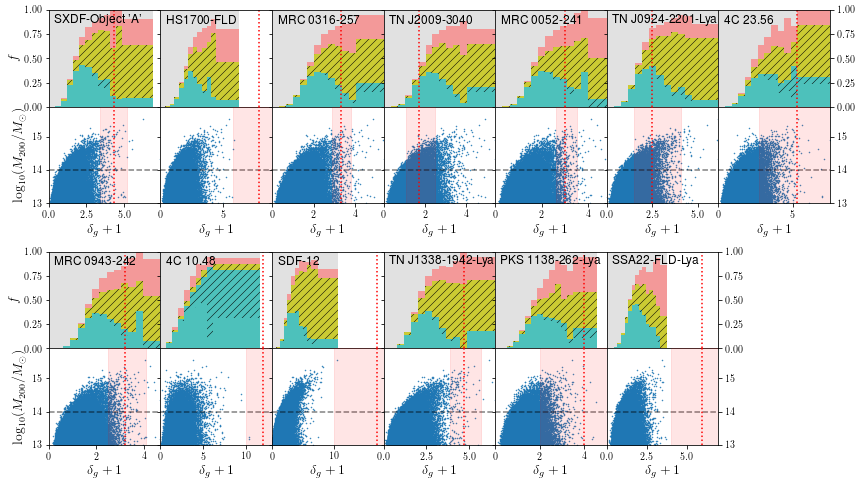

In [36]:
fig = plt.figure(figsize=(14, 8))

gs = gridspec.GridSpec(9, 7)
gs.update(hspace=0, wspace=0)

axt = {'top': [None] * 7, 'bottom': [None] * 7}
axb = {'top': [None] * 6, 'bottom': [None] * 6}

for i in range(7):    
    axt['top'][i] = fig.add_subplot(gs[0:2,i])
    axt['bottom'][i] = fig.add_subplot(gs[2:4,i])
    
    if i < 6:
        axb['top'][i] = fig.add_subplot(gs[5:7,i])
        axb['bottom'][i] = fig.add_subplot(gs[7:9,i])

    
for i, (key, value) in enumerate(chiang13.iteritems()):
    
    if i < 7:
        ax = {'top': axt['top'][i], 'bottom': axt['bottom'][i]}
    else:
        ax = {'top': axb['top'][i-7], 'bottom': axb['bottom'][i-7]}
        
#     fig, ax = plt.subplots(1, 2, figsize=(6,2.5))
    
    ax['top'].text(0.05, 0.87, u'%s'%key, size=12, transform=ax['top'].transAxes)
#     ax[0].text(0.7, 0.6, u'$C_{lim}$: %s'%chiang13[key]['clim_chosen'], size=15)
#     ax[0].text(0.7, 0.4, u'$P_{lim}$: %s'%chiang13[key]['plim_chosen'], size=15)
#     ax[0].text(0.7, 0.2, u'$R$: %.2f Dc: %.2f'%(chiang13[key]['R'], chiang13[key]['deltac']), size=15)

    plotit(ax['top'], chiang13[key]['stats'], axb=None, N=N, clim=chiang13[key]['clim_chosen'], 
           plim=chiang13[key]['plim_chosen'], minimum=minimum);
    
    if (i == 0) | (i == 7):
        ax['top'].set_ylabel('$f$', size=14)
        ax['bottom'].set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$', size=14)
    elif (i==6) | (i==12):
        ax['top'].yaxis.set_ticks_position('right')
        ax['bottom'].yaxis.set_ticks_position('right')
    else:
        ax['top'].set_yticklabels([])
        ax['bottom'].set_yticklabels([])
        
    
    ax['top'].set_xticklabels([])
    ax['bottom'].set_xlabel('$\delta_{g} + 1$', size=14)
    
    fit_mask = chiang13[key]['dgal'] > chiang13[key]['dgal_threshold'];

#     x = np.zeros((chiang13[key]['dgal'].shape[0], 2));  # create feature array
#     x[:,0] = chiang13[key]['dgal'];
#     x[:,1] = chiang13[key]['z'];
#     popt, pcov = curve_fit(fit_func, x[fit_mask,:].T, chiang13[key]['mass'][fit_mask], maxfev=20000);

    ax['bottom'].plot(chiang13[key]['dgal'] + 1, np.log10(chiang13[key]['mass'] * 1e10), '.', markersize=1);

#     dgal_range = np.linspace(chiang13[key]['dgal_threshold'], chiang13[key]['dgal'].max() + 1, len(x[:,1]));
#     ax[1].plot(dgal_range, scale(fit_func(np.vstack([dgal_range, x[:,1]]), popt[0], popt[1], popt[2], popt[3])));
#     ax[1].vlines(chiang13[key]['dgal_threshold'], 13,16,linestyle='dashed', alpha=0.5, zorder=10);
    
    ax['bottom'].set_ylim(13,15.9);
    
    # add observational values
    dgal =  [None,None,None]
    dgal[0] = chiang13[key]['dgal_chiang'][0] + 1
    dgal[1] = dgal[0] + chiang13[key]['dgal_chiang'][1]
    dgal[2] = dgal[0] - chiang13[key]['dgal_chiang'][2]
    
    print key, dgal, chiang13[key]['dgal_chiang']
    
    ax['top'].vlines(dgal[0], 0, 1, linestyle='dotted', color='red')
#     ax['top'].axvspan(dgal[1], dgal[2], color='red', alpha=0.1, zorder=10)
    
    ax['bottom'].vlines(chiang13[key]['dgal_chiang'][0] + 1, 13, 16, linestyle='dotted', color='red', zorder=20)
    ax['bottom'].axvspan(dgal[1], dgal[2], color='red', alpha=0.1, zorder=10)
    
    for a in [ax['top'], ax['bottom']]:
        a.set_xlim(0, max(chiang13[key]['dgal_chiang'][0] + 2, np.max(chiang13[key]['dgal']) + 1))
    
    
    ax['bottom'].hlines(14, 0, ax['bottom'].get_xlim()[1], linestyle='dashed', alpha=0.5, zorder=10);
    
    
# plt.savefig(out_directory+'chiang13_prob.png', bbox_inches='tight', dpi=300)